In [30]:
# Libraries
import os
from PIL import Image, ImageEnhance
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score


Preprocessing

In [24]:
def preprocess_image(image_path, size=(224, 224)):
    img = Image.open(image_path)
    
    # Quality enhancement
    enhancer = ImageEnhance.Sharpness(img)
    img = enhancer.enhance(2.0)  # Increase sharpness
    
    # Noise reduction
    image = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    image = cv2.GaussianBlur(image, (5, 5), 0)
    img = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    
    # Consistency
    img = img.resize(size, Image.LANCZOS)
    
    # Normalization
    img_array = np.array(img) / 255.0
    
    # Convert back to image
    img = Image.fromarray((img_array * 255).astype(np.uint8))
    
    return img

# Apply preprocessing and save to new directory
input_dir = 'images_train_test_val/train'
output_dir = 'processed_images'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for category in os.listdir(input_dir):
    category_path = os.path.join(input_dir, category)
    if os.path.isdir(category_path):
        output_category_path = os.path.join(output_dir, category)
        if not os.path.exists(output_category_path):
            os.makedirs(output_category_path)
        for image_name in os.listdir(category_path):
            image_path = os.path.join(category_path, image_name)
            preprocessed_img = preprocess_image(image_path)
            preprocessed_img.save(os.path.join(output_category_path, image_name))

Train/Test Split

In [25]:
train_dir = 'processed_images'
test_dir = 'images_train_test_val/test'

datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],  # Randomly adjust brightness
    rotation_range=20,  # Randomly rotate images
    width_shift_range=0.2,  # Randomly shift images horizontally
    height_shift_range=0.2  # Randomly shift images vertically
)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 10500 images belonging to 21 classes.
Found 1050 images belonging to 21 classes.


Base Model Creation

In [26]:
def create_model(optimizer='adam', init_mode='uniform'):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(224, 224, 3), activation='relu', kernel_initializer=init_mode))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer=init_mode))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer=init_mode))
    model.add(Dropout(0.5))
    model.add(Dense(21, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

Model Creation

In [27]:
model = create_model()
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=test_generator
)

Epoch 1/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 1376s 556ms/step - accuracy: 0.0508 - loss: 3.0518 - val_accuracy: 0.1048 - val_loss: 2.9737
Epoch 2/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 1973s 6s/step - accuracy: 0.0847 - loss: 2.9820 - val_accuracy: 0.1152 - val_loss: 2.8150
Epoch 3/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 6141s 19s/step - accuracy: 0.1030 - loss: 2.8540 - val_accuracy: 0.1848 - val_loss: 2.6132
Epoch 4/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 6929s 21s/step - accuracy: 0.1292 - loss: 2.7259 - val_accuracy: 0.1638 - val_loss: 2.5778
Epoch 5/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 3309s 10s/step - accuracy: 0.1624 - loss: 2.6418 - val_accuracy: 0.2448 - val_loss: 2.3868
Epoch 6/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 7248s 22s/step - accuracy: 0.2030 - loss: 2.5167 - val_accuracy: 0.2457 - val_loss: 2.3167
Epoch 7/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 7617s 23s/step - accuracy: 0.2147 - loss: 2.4482 - val_accuracy: 0.2857 - val_loss: 2.2602
Epoch 8/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 8802s 27s/step - accuracy: 0.2275 - loss: 

In [28]:
# Evaluate the model
train_loss, train_acc = model.evaluate(train_generator)
val_loss, val_acc = model.evaluate(test_generator)

print(f'Train accuracy: {train_acc:.4f}, Test accuracy: {val_acc:.4f}')

329/329 ━━━━━━━━━━━━━━━━━━━━ 84s 255ms/step - accuracy: 0.3681 - loss: 1.9468
33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 288ms/step - accuracy: 0.3940 - loss: 1.8551
Train accuracy: 0.3667, Test accuracy: 0.3952


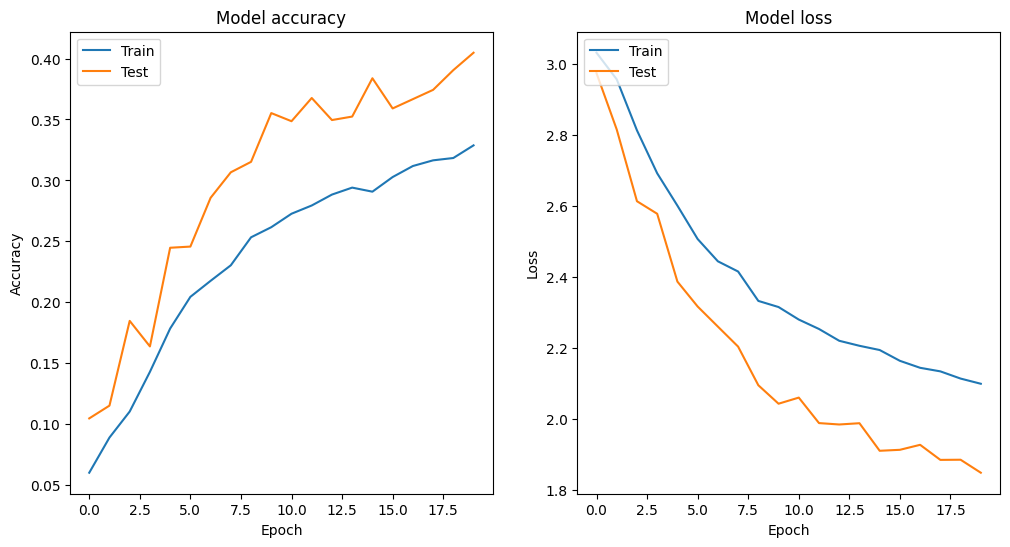

In [29]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & Test loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()
